# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.shape

(10, 6)

In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
profile.shape

(17000, 5)

In [6]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [7]:
transcript.shape

(306534, 4)

## Check the Dataset

In [8]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [9]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [10]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


It seems we have a certain anomaly here, wehere the age of a certain customer is 118. This needs further investigation later on.

In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [12]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [13]:
portfolio_df = portfolio.copy()
portfolio_df['offer_id'] = list(range(10))

In [14]:
portfolio_df

,channels,difficulty,duration,id,offer_type,reward,offer_id
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,2
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,3
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,4
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,5
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,6
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,7
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,8
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,9


In the above cell, we created a new column named **offer_id**, which will be used to modify the demographic and transaction data later on.

In [15]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


As mentioned before, it seems that he customer dat contains null values. However, it seems that these null values are adjoint with the unsual values in the data. For example, a customer has an age of 118 and their gender and income are null.

In [16]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [17]:
len(profile[profile['age'] == 118])

2175

In [18]:
null_user_size = len(profile[profile['age'] == 118])
customer_size = profile.shape[0]
                     
round(null_user_size / customer_size,3) * 100

12.8

It seems that the user with the age of 118 makes up of almost **13%** of the whole demographic data. That is not a large, but still quite a significant proportion. To be sure, let's see how much do these users contribute to the transaction data.

In [19]:
null_customer_ids = profile[profile['age'] == 118]['id'].values.tolist()

In [20]:
null_customer_size = transcript[transcript.person.isin(null_customer_ids)].shape[0]
transaction_size = transcript.shape[0]

round(null_customer_size / transaction_size,3) * 100

11.0

Around **11%**. Again, is not a big, but quite significant. However, I think it is safe to say we can drop the values here. While at it, we can also confirm if these users are the cause for the null values in our dataset.

In [21]:
profile_df = profile.copy()
profile_df = profile_df[profile_df['age'] != 118]

In [22]:
profile_df.isnull().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

Look at that, looks like our assumption was right. It seems there was an error during the entry process of the data.

Now that we got the null value out of the way, maybe we can do some visualization to know more about about our customer. Some of the thing we can get insight visually is by exploring some variables like gender, age, and income.

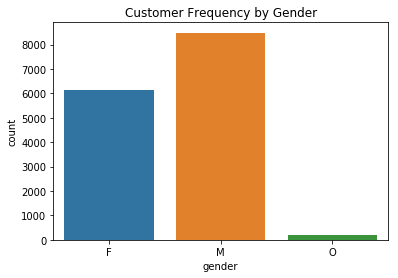

In [23]:
plt.title("Customer Frequency by Gender")
sns.countplot(x='gender', data=profile_df)

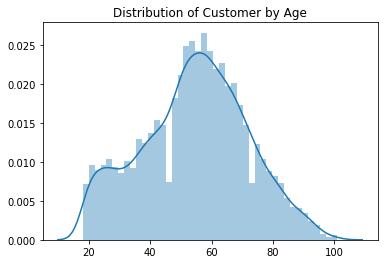

In [24]:
plt.title("Distribution of Customer by Age")
sns.distplot(profile_df['age'].values.tolist())

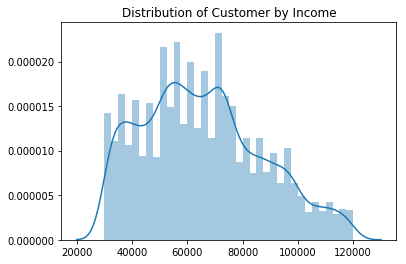

In [25]:
plt.title("Distribution of Customer by Income")
sns.distplot(profile_df['income'].values.tolist())

Based in the plots, in terms of gender, male customers are the most common with female customer coming in second. Furthermore, it seems that customer who are in the age of 50-70 are the most common; and also those with an between around 50,000 - 78,000 are the most common.

Since the customer ids are a little bit hard to read, I think it's better if we create seperate ids so that it's more readable. We'll name a new column named **customer_id** that will include the new ids.

In [26]:
profile_df['customer_id'] = list(range(len(profile_df)))

In [27]:
profile_df.head()

,age,became_member_on,gender,id,income,customer_id
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,2
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,3
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,4


We were able to gain some understanding about our customer. However, we still need to understand about how our customets interact with the offers. Therefore, we need to know more about our transaction data.

In [28]:
wanted_ids = profile_df.id.values.tolist()

In [29]:
transcript.shape

(306534, 4)

In [30]:
transcript_df = transcript[transcript['person'].isin(wanted_ids)]
transcript_df.shape

(272762, 4)

In [31]:
transcript_df.columns

Index(['event', 'person', 'time', 'value'], dtype='object')

In [32]:
transcript_df.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [33]:
ids_dict = profile_df[['id', 'customer_id']].set_index("id").to_dict()['customer_id']

transcript_df['customer_id'] = transcript_df['person'].apply(lambda x: ids_dict[x])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
transcript_df.head()

,event,person,time,value,customer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},3
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},4
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},5


In [35]:
transcript_df.customer_id.value_counts()

2699     51
5554     49
8936     48
5214     48
5821     48
3418     46
14422    46
1277     46
5077     46
5649     44
11237    43
10117    43
6841     43
9371     43
13891    43
6713     42
4047     42
3706     42
6739     42
1867     42
13479    42
13553    41
7627     41
14031    41
3666     41
10672    41
11330    41
1293     41
7012     41
837      41
         ..
745       4
7001      4
7445      4
3489      4
6275      4
6307      4
12829     4
4036      3
9049      3
7497      3
10340     3
12094     3
9275      3
5920      3
3275      3
11942     3
5933      3
889       3
10032     3
13442     3
7838      3
6179      3
14314     2
12298     2
6230      2
10390     2
10543     2
487       2
12539     2
12111     2
Name: customer_id, Length: 14825, dtype: int64

In [36]:
transcript_df[transcript_df.customer_id == 2699]

,event,person,time,value,customer_id
2276,offer received,94de646f7b6041228ca7dec82adb97d2,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},2699
16010,offer viewed,94de646f7b6041228ca7dec82adb97d2,6,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},2699
24531,transaction,94de646f7b6041228ca7dec82adb97d2,30,{'amount': 7.41},2699
24532,offer completed,94de646f7b6041228ca7dec82adb97d2,30,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,2699
42252,transaction,94de646f7b6041228ca7dec82adb97d2,102,{'amount': 1.47},2699
55475,offer received,94de646f7b6041228ca7dec82adb97d2,168,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},2699
75256,offer viewed,94de646f7b6041228ca7dec82adb97d2,186,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},2699
77624,transaction,94de646f7b6041228ca7dec82adb97d2,192,{'amount': 2.62},2699
81725,transaction,94de646f7b6041228ca7dec82adb97d2,204,{'amount': 0.59},2699
93913,transaction,94de646f7b6041228ca7dec82adb97d2,246,{'amount': 2.2800000000000002},2699


In [37]:
portfolio_df[portfolio_df.id == '9b98b8c7a33c4b65b9aebfe6a799e6d9']

,channels,difficulty,duration,id,offer_type,reward,offer_id
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,3


In [38]:
transcript_df[
    ((transcript_df['event'] == "offer completed") | (transcript_df['event'] == "offer viewed")) \
    & (transcript_df['time'] != 0) & (transcript_df['customer_id'] == 2699)
]

,event,person,time,value,customer_id
16010,offer viewed,94de646f7b6041228ca7dec82adb97d2,6,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},2699
24532,offer completed,94de646f7b6041228ca7dec82adb97d2,30,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,2699
75256,offer viewed,94de646f7b6041228ca7dec82adb97d2,186,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},2699
99191,offer completed,94de646f7b6041228ca7dec82adb97d2,270,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,2699
164148,offer viewed,94de646f7b6041228ca7dec82adb97d2,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},2699
171736,offer completed,94de646f7b6041228ca7dec82adb97d2,420,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,2699
198780,offer completed,94de646f7b6041228ca7dec82adb97d2,492,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,2699
222483,offer viewed,94de646f7b6041228ca7dec82adb97d2,516,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},2699
275002,offer completed,94de646f7b6041228ca7dec82adb97d2,606,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,2699
282196,offer viewed,94de646f7b6041228ca7dec82adb97d2,624,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},2699


In [39]:
transcript_df[
    (transcript_df['event'] != "transaction") \
    & (transcript_df['time'] != 0) \
    & (transcript_df['customer_id'] == 2699)
]

,event,person,time,value,customer_id
16010,offer viewed,94de646f7b6041228ca7dec82adb97d2,6,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},2699
24532,offer completed,94de646f7b6041228ca7dec82adb97d2,30,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,2699
55475,offer received,94de646f7b6041228ca7dec82adb97d2,168,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},2699
75256,offer viewed,94de646f7b6041228ca7dec82adb97d2,186,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},2699
99191,offer completed,94de646f7b6041228ca7dec82adb97d2,270,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,2699
113102,offer received,94de646f7b6041228ca7dec82adb97d2,336,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},2699
152891,offer received,94de646f7b6041228ca7dec82adb97d2,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},2699
164148,offer viewed,94de646f7b6041228ca7dec82adb97d2,408,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},2699
171736,offer completed,94de646f7b6041228ca7dec82adb97d2,420,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,2699
198780,offer completed,94de646f7b6041228ca7dec82adb97d2,492,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,2699


In [40]:
transcript_no_transaction_df = transcript_df[transcript_df['event'] != "transaction"]
transcript_no_transaction_df.head()

,event,person,time,value,customer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},3
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},4
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},5


In [41]:
offer_ids_dict = portfolio_df[['id', 'offer_id']].set_index("id").to_dict()['offer_id']

def make_offer_id_col(offer_dict, offer_ids_dict=offer_ids_dict):
    
    offer_key = list(offer_dict.keys())[0]
    
    if (offer_key == "offer id") or offer_key == "offer_id":
        offer_value = list(offer_dict.values())[0]
        return offer_ids_dict[offer_value]

In [42]:
transcript_no_transaction_df['offer_id'] = transcript_no_transaction_df['value'].apply(make_offer_id_col)
transcript_no_transaction_df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,event,person,time,value,customer_id,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1,3
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2,9
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},3,8
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},4,2
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},5,4


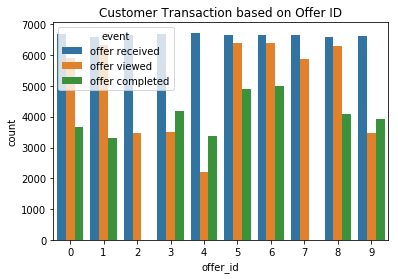

In [44]:
plt.title("Customer Transaction based on Offer ID")
sns.countplot(x="offer_id", hue="event", data=transcript_no_transaction_df)

## Feature Engineering

Based on the chart above, we know have some understanding about which offers have high conversions. 

First, just like a funnel on a website, we want to find the offer that moves from large number during the 'offer recieved' phase, to smaller numbers during the 'offer completed phase'. According to the graph, the offers that seems to mathc the criteria are offer 0, 1, 5, 6, and 8.

Second, there are events where the offers were not actually attractive to the customers. Although used, they are not in the mind of the customer. These offers include offer 3, 4, and 9.

Finally, informational notice cannot be converted to purchases. This includes offer 2 and 7.



Now that we know which offer is effective and which are not, we can use this information to provide labels for the demographic data. Basically, we want to label if a certain individual will make a purchase if given the effective offers. 

We can do this by looking at the transaction data. For each person that has the effective offer, we consider those customers as most likely to convert.

In [53]:
def get_amount_or_offer_id(value_dict):
    
    key = list(value_dict.keys())[0]
    
    return value_dict[key]

In [54]:
transcript_no_transaction_df['amount'] = transcript_no_transaction_df.value.apply(get_amount_or_offer_id)
transcript_no_transaction_df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,event,person,time,value,customer_id,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},1,3,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2,9,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},3,8,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},4,2,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},5,4,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [59]:
# Transaction with customer id 2699
customer2699_transaction_df = transcript_no_transaction_df[transcript_no_transaction_df.customer_id == 2699]

# Customer 2699 transactions with completed offer (no duplicates)
customer2699_completed_df = customer2699_transaction_df[customer2699_transaction_df.event == "offer completed"]
customer2699_completed_df = customer2699_completed_df.drop_duplicates(subset="amount", keep="first")
customer2699_completed_df.head()

,event,person,time,value,customer_id,offer_id,amount
24532,offer completed,94de646f7b6041228ca7dec82adb97d2,30,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,2699,8,f19421c1d4aa40978ebb69ca19b0e20d
99191,offer completed,94de646f7b6041228ca7dec82adb97d2,270,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,2699,3,9b98b8c7a33c4b65b9aebfe6a799e6d9
171736,offer completed,94de646f7b6041228ca7dec82adb97d2,420,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,2699,6,fafdcd668e3743c1bb461111dcafc2a4
198780,offer completed,94de646f7b6041228ca7dec82adb97d2,492,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7...,2699,4,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [60]:
customer2699_completed_df.amount.values.tolist()

['f19421c1d4aa40978ebb69ca19b0e20d',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 'fafdcd668e3743c1bb461111dcafc2a4',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7']

In [61]:
portfolio_df

,channels,difficulty,duration,id,offer_type,reward,offer_id
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,2
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,3
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,4
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,5
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,6
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,7
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,8
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,9


In [64]:
effective_offers = [0, 1, 5, 6, 8]
effective_offer_ids = portfolio_df[portfolio_df.offer_id.isin(effective_offers)].id.values.tolist()
effective_offer_ids

['ae264e3637204a6fb9bb56bc8210ddfd',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 'fafdcd668e3743c1bb461111dcafc2a4',
 'f19421c1d4aa40978ebb69ca19b0e20d']

In [69]:
def customers_effective_offers(customer_id, 
                               transcript_df=transcript_no_transaction_df, 
                               portfolio_df=portfolio_df):
    
    # Get customer's transaction data with no "transaction" value
    customer_transaction_df = transcript_df[transcript_df.customer_id == customer_id]
    
    # Get rows with "offer completed" values
    customer_completed_df = customer_transaction_df[customer_transaction_df.event == "offer completed"]
    
    # Remove duplicates
    customer_completed_df = customer_completed_df.drop_duplicates(subset="amount", keep="first")
    
    # Get customer's offer ids
    customer_offer_ids = customer_completed_df.amount.values.tolist()
    
    # All effective offer ids
    effective_offers = [0, 1, 5, 6, 8]
    effective_offer_ids = portfolio_df[portfolio_df.offer_id.isin(effective_offers)].id.values.tolist()
    
    
    # Return 1 if customer offer ids is in effective ids else 0
    if any(customer_offer_id in effective_offer_ids for customer_offer_id in customer_offer_ids): 
        return 1
    else: 
        return 0

In [73]:
customers_effective_offers(2699)

1

In [72]:
customers_effective_offers(12111)

0

In [75]:
profile_df['offer_converted'] = profile_df.customer_id.apply(customers_effective_offers)
profile_df.head()

,age,became_member_on,gender,id,income,customer_id,offer_converted
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,1
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,2,1
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,3,1
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,4,1


In [77]:
ready_df = profile_df[['age', 'gender', 'income', 'offer_converted']]
ready_df.head()

,age,gender,income,offer_converted
1,55,F,112000.0,0
3,75,F,100000.0,1
5,68,M,70000.0,1
8,65,M,53000.0,1
12,58,M,51000.0,1


In [79]:
ready_df.groupby("gender").count()

,age,income,offer_converted
gender,,,
F,6129,6129,6129
M,8484,8484,8484
O,212,212,212


In [127]:
ready_df.groupby("offer_converted").count()

,age,gender,income
offer_converted,,,
0,4181,4181,4181
1,10644,10644,10644


## Preprocessing

In [130]:
X = ready_df.drop("offer_converted", axis=1)
y = ready_df['offer_converted']

In [131]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
var_scaled = scale.fit_transform(ready_df[['age', 'income']])

X['age'] = X_scaled[:,0].flatten().tolist()
X['income'] = X_scaled[:,1].flatten().tolist()

In [132]:
X_ready = pd.get_dummies(X).drop("gender_O", axis=1)

In [133]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ready, y, test_size=.15, random_state=42)

In [134]:
X_train.shape, y_train.shape

((12601, 4), (12601,))

In [135]:
X_test.shape, y_test.shape

((2224, 4), (2224,))

In [136]:
corr_matrix_df = pd.get_dummies(X.copy())
corr_matrix_df['offer_converted'] = y.values.tolist()
corr_matrix_df.corr()['offer_converted']

age                0.081235
income             0.201844
gender_F           0.136227
gender_M          -0.137953
gender_O           0.009834
offer_converted    1.000000
Name: offer_converted, dtype: float64

## Modelling and Model Evaluation

It seems that using accuracy would not be practical since the data is qute imbalanced. Therfore we have to turn to **precision**, **recall**, and **f-1 score** as the metrics we will used to measure the peformance of our model.

In [137]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [138]:
from sklearn.metrics import classification_report

y_pred = logreg.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       620
          1       0.72      1.00      0.84      1604

avg / total       0.52      0.72      0.60      2224



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [141]:
logreg.score(X_train, y_train)

0.71740338068407272

In [142]:
logreg.score(X_test, y_test)

0.72122302158273377

In [149]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.1, 0.5,1.0, 2.0, 10.0 ]
}

logreg = LogisticRegression()

cv = GridSearchCV(logreg, param_grid)
cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 0.5, 1.0, 2.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [150]:
cv.best_params_

{'C': 0.1, 'penalty': 'l1'}

In [152]:
y_pred = cv.best_estimator_.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       620
          1       0.72      1.00      0.84      1604

avg / total       0.52      0.72      0.60      2224



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [153]:
cv.best_estimator_.score(X_train, y_train)cv.best_estimator_.score(X_train, y_train)

0.71740338068407272

In [154]:
cv.best_estimator_.score(X_test, y_test)

0.72122302158273377

It seems that simple model like Logistic Regression would not be able to deal with the case. Therefore we might need to use other algorithm that can handle the complexity of the data.

In [166]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [168]:
y_pred = forest.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       0.35      0.30      0.32       620
          1       0.74      0.78      0.76      1604

avg / total       0.63      0.65      0.64      2224



In [169]:
forest.score(X_train, y_train)

0.83906039203237837

In [171]:
forest.score(X_test, y_test)

0.64883093525179858

In [183]:
param_grid = {
    "n_estimators": [5, 10, 15],
    "max_depth": [10, 50, 100],
    "min_samples_split": [0.1, 0.3, 0.5, 1.0],
    "min_samples_leaf": [1, 2, 3],
}

forest = RandomForestClassifier()

cv = GridSearchCV(forest, param_grid)
cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15], 'max_depth': [10, 50, 100], 'min_samples_split': [0.1, 0.3, 0.5, 1.0], 'min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [188]:
cv.best_params_

{'max_depth': 100,
 'min_samples_leaf': 2,
 'min_samples_split': 0.1,
 'n_estimators': 5}

In [189]:
y_pred = cv.best_estimator_.predict(X_test)
print(classification_report(y_pred=y_pred, y_true=y_test))

             precision    recall  f1-score   support

          0       1.00      0.00      0.01       620
          1       0.72      1.00      0.84      1604

avg / total       0.80      0.72      0.61      2224



In [190]:
cv.best_estimator_.score(X_train, y_train)

0.71732402190302358

In [191]:
cv.best_estimator_.score(X_test, y_test)

0.72257194244604317

In [192]:
cv.best_estimator_.feature_importances_

array([ 0.09827711,  0.67806937,  0.03594144,  0.18771208])

## Conclusion

We analyze data about Starbucks customers to understand their behaviors towards purchasing when given certain offers. 

The step we went through include exploring the data, engineering features ad labels and building machine learning models.
During the process of exploring the data, we're able to intercept missing values in the data. The missing values were most likely caused by some error during the data entry process. 

We were also able to find offers that are mostly to attract customers into purchasing. It seems that customers are attracted to offer 0, 1, 5, 6, and 8.

In the feature engineering process, we were able to create a dataset that was ready to be preprocessed and trained using a machine learning algorithm.

Finally, in building the machine learning model, we preprocessed the data by scaling numerical features and creating dummy variables for categorical features. 

After preprocessing, we used two machine learning algorithms to build the model: Logistic Regression and Random Forest. In order to improve performance, we use a combination of cross-validation and grid-search.

We also found out that even though the dataset is small, it is quite complex and simple algorithms would not do the job. 
This could be improved by adding more features like the channels on the offer dataset and measure the difference in performance.